# Real data experiment and visualization

This experiment is based on the paper of "Interpreting Intermittent Bugs in Mozilla Application Using Change Angle".

## General idea

This dataset used by the experiment comes from Bugzilla application real data, which contains a couple of attributes for each data instance, but here we only focus on two attributes, timestamp and bug, latter one represents unique bug NO while another means the time when this bug happens. The number of bugs within certain time period would be used as data stream, then feeding the change detector, some of bugs are plotted at end to visulaze the whole process.

## Import dataset and fetch required columns

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from skmultiflow.drift_detection import ANGLE

df = pd.read_csv("OF.csv")
df.head(5)

,rownum,buildtype,who,type,machinename,treeherder_job_id,rev,tree,buildname,starttime,timestamp,date,logfile,os,bug
0,289657,opt,edmorley,Mochitest,talos-mtnlion-r5-028,NaN,9e8c00218dcc,integration/fx-team,Rev5 MacOSX Mountain Lion 10.8 fx-team opt tes...,1403194588,1403197644,1403136000,42062271.0,osx-10-8,0
1,166732,opt,RyanVM,Reftest,talos-r3-fed-099,NaN,41729438f597,integration/fx-team,b2g_emulator fx-team opt test reftest-5,1377803561,1377805936,1377734400,27189526.0,b2g-emu,1
2,218232,debug,Tomcat,XPCShellTest,t-w864-ix-049,NaN,f2d7d00e6dcf,integration/mozilla-inbound,WINNT 6.2 mozilla-inbound debug test xpcshell,1389096692,1389102772,1389052800,32635213.0,windows8-32,2
3,194495,pgo,Tomcat,Mochitest Other,tst-linux32-ec2-336,NaN,a0a669819300,integration/mozilla-inbound,Ubuntu VM 12.04 mozilla-inbound pgo test mochi...,1382705118,1382706327,1382659200,29657150.0,linux32,4
4,199739,pgo,Tomcat,Mochitest,tst-linux32-ec2-040,NaN,a0a669819300,integration/mozilla-inbound,Ubuntu VM 12.04 mozilla-inbound pgo test mochi...,1382705122,1382706327,1382659200,29656970.0,linux32,4


In [2]:
dataset = df[["timestamp", "bug"]]
dataset.head(10)

,timestamp,bug
0,1403197644,0
1,1377805936,1
2,1389102772,2
3,1382706327,4
4,1382706327,4
5,1382706327,4
6,1382706327,4
7,1369143095,78
8,1365515595,81
9,1368039624,948


## Convert data into dictionary structure (key = Bug No, value = timestamp)

In [3]:
bug_dic = {}
for index, row in dataset.iterrows():
    bug_no = row["bug"]
    if bug_no not in bug_dic:
        bug_dic[bug_no] = [row["timestamp"]]
    else:
        bug_dic[bug_no].append(row["timestamp"])


## Generate hour-based stream for each bug 

In [11]:
def stream_generation(time_list, start, end):
    hours = (end - start) // 3600
    stream = [0] * hours
    
    for time in time_list:
        index = (time - start) // 3600
        stream[index] += 1
    return stream

## Process each bugs and generate report

In [15]:
data_stream = []
for key in bug_dic:
    bug_list = bug_dic[key]
    if len(bug_list) > 100:
        bug_list.sort()
        #print("Generate data stream per hour for bug NO", key)
        start_time = int(datetime.datetime.fromtimestamp(bug_list[0] // 86400 * 86400).timestamp())
        end_time = int(datetime.datetime.fromtimestamp((bug_list[-1] // 86400 + 1) * 86400).timestamp())
        data_stream = stream_generation(bug_list, start_time, end_time)
        #print("Data stream from", bug_dic[key][0][1], " and end with", bug_dic[key][0][1]+86400)
        index = 0
        angle = ANGLE(block_size=1)
        for data in data_stream:
            index += 1
            angle.add_element(data)
            if angle.detected_change() and data > 5 and angle.get_difference() > 19:
                print("Data stream", key, "from", datetime.datetime.fromtimestamp(start_time), " and end with", datetime.datetime.fromtimestamp(end_time))
                print("Change detected happend is on index of", index, " with data", data)
                true_point = index - angle.get_drift_location()
                print("The possible true change point is on index of", true_point)
                difference = angle.get_difference()
                print("The diff of this drift is", difference)
                print("----------------------------------------------------------------------------")
                break

Data stream 669384 from 2013-09-12 12:00:00  and end with 2014-03-31 13:00:00
Change detected happend is on index of 2536  with data 32
The possible true change point is on index of 2533
The diff of this drift is 32.0
----------------------------------------------------------------------------
Data stream 710942 from 2013-03-15 13:00:00  and end with 2014-01-14 13:00:00
Change detected happend is on index of 607  with data 52
The possible true change point is on index of 589
The diff of this drift is 50.666666666666664
----------------------------------------------------------------------------
Data stream 711725 from 2013-03-14 13:00:00  and end with 2013-10-25 13:00:00
Change detected happend is on index of 2156  with data 73
The possible true change point is on index of 1864
The diff of this drift is 72.65423728813559
----------------------------------------------------------------------------
Data stream 739089 from 2013-03-17 13:00:00  and end with 2014-05-29 12:00:00
Change detec

Data stream 906716 from 2013-08-19 12:00:00  and end with 2015-08-22 12:00:00
Change detected happend is on index of 7091  with data 24
The possible true change point is on index of 6952
The diff of this drift is 23.280575539568346
----------------------------------------------------------------------------
Data stream 906782 from 2013-08-19 12:00:00  and end with 2013-08-20 12:00:00
Change detected happend is on index of 21  with data 187
The possible true change point is on index of 18
The diff of this drift is 186.95
----------------------------------------------------------------------------
Data stream 909147 from 2013-08-25 12:00:00  and end with 2013-09-17 12:00:00
Change detected happend is on index of 533  with data 40
The possible true change point is on index of 465
The diff of this drift is 39.48529411764706
----------------------------------------------------------------------------
Data stream 910190 from 2013-08-28 12:00:00  and end with 2013-08-31 12:00:00
Change detect

Data stream 980997 from 2014-03-07 13:00:00  and end with 2014-05-28 12:00:00
Change detected happend is on index of 935  with data 43
The possible true change point is on index of 919
The diff of this drift is 42.1875
----------------------------------------------------------------------------
Data stream 983678 from 2014-03-14 13:00:00  and end with 2014-03-15 13:00:00
Change detected happend is on index of 16  with data 79
The possible true change point is on index of 13
The diff of this drift is 79.0
----------------------------------------------------------------------------
Data stream 984194 from 2014-03-17 13:00:00  and end with 2014-10-24 13:00:00
Change detected happend is on index of 1396  with data 21
The possible true change point is on index of 1266
The diff of this drift is 20.953846153846154
----------------------------------------------------------------------------
Data stream 985155 from 2014-03-21 13:00:00  and end with 2014-04-28 12:00:00
Change detected happend is

Data stream 1054308 from 2014-09-10 12:00:00  and end with 2015-04-04 13:00:00
Change detected happend is on index of 4732  with data 30
The possible true change point is on index of 4729
The diff of this drift is 30.0
----------------------------------------------------------------------------
Data stream 1059287 from 2014-08-27 12:00:00  and end with 2015-08-21 12:00:00
Change detected happend is on index of 29  with data 33
The possible true change point is on index of 13
The diff of this drift is 32.964285714285715
----------------------------------------------------------------------------
Data stream 1060407 from 2014-08-29 12:00:00  and end with 2014-08-31 12:00:00
Change detected happend is on index of 17  with data 265
The possible true change point is on index of 14
The diff of this drift is 265.0
----------------------------------------------------------------------------
Data stream 1061789 from 2014-09-02 12:00:00  and end with 2014-09-03 12:00:00
Change detected happend i

Data stream 1143063 from 2015-03-13 13:00:00  and end with 2015-03-22 13:00:00
Change detected happend is on index of 18  with data 29
The possible true change point is on index of 15
The diff of this drift is 29.0
----------------------------------------------------------------------------
Data stream 1143065 from 2015-03-13 13:00:00  and end with 2015-03-22 13:00:00
Change detected happend is on index of 18  with data 29
The possible true change point is on index of 15
The diff of this drift is 29.0
----------------------------------------------------------------------------
Data stream 1143380 from 2015-03-15 13:00:00  and end with 2015-08-15 12:00:00
Change detected happend is on index of 254  with data 45
The possible true change point is on index of 241
The diff of this drift is 42.47826086956522
----------------------------------------------------------------------------
Data stream 1147271 from 2015-03-29 13:00:00  and end with 2015-08-23 12:00:00
Change detected happend is on 

Data stream 1165765 from 2015-05-18 12:00:00  and end with 2015-08-24 12:00:00
Change detected happend is on index of 1876  with data 20
The possible true change point is on index of 1721
The diff of this drift is 19.80128205128205
----------------------------------------------------------------------------
Data stream 1167986 from 2015-05-24 12:00:00  and end with 2015-08-13 12:00:00
Change detected happend is on index of 638  with data 24
The possible true change point is on index of 546
The diff of this drift is 23.978448275862068
----------------------------------------------------------------------------
Data stream 1168363 from 2015-05-26 12:00:00  and end with 2015-08-20 12:00:00
Change detected happend is on index of 831  with data 25
The possible true change point is on index of 689
The diff of this drift is 24.21383647798742
----------------------------------------------------------------------------
Data stream 1174323 from 2015-06-12 12:00:00  and end with 2015-07-28 12:00:

| Bug No. | detected point | true point | diff |
| --- | --- | --- | --- |
| 669384 | 2536 | 2533 | 3 |
| 710942 | 607 | 589 | 18 |
| 739089 | 3647 | 3618 | 29 |
| 840305 | 933 | 928 | 5 |
| 906690 | 60 | 49 | 11 |
| 913870 | 7495 | 7488 | 7 |
| 918759 | 2602 | 2575 | 27 |
| 934310 | 5767 | 5764 | 3 |
| 980997 | 935 | 919 | 16 |
| 989048 | 6470 | 6386 | 84 |

## Visulization for Bug 669384

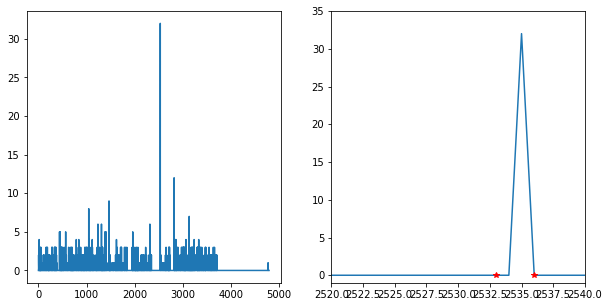

In [68]:
bug = bug_dic[669384]
bug.sort()
start_time = int(datetime.datetime.fromtimestamp(bug[0] // 86400 * 86400).timestamp())
end_time = int(datetime.datetime.fromtimestamp((bug[-1] // 86400 + 1) * 86400).timestamp())
data_stream = stream_generation2(bug, start_time, end_time)
fig = plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(data_stream)

plt.subplot(1, 2, 2)
plt.plot(data_stream)
plt.axis([2520, 2540, -1, 35])
plt.plot(2533, data_stream[2533], 'r*')
plt.plot(2536, data_stream[2536], 'r*')

plt.show()


## Visulization for Bug 710942

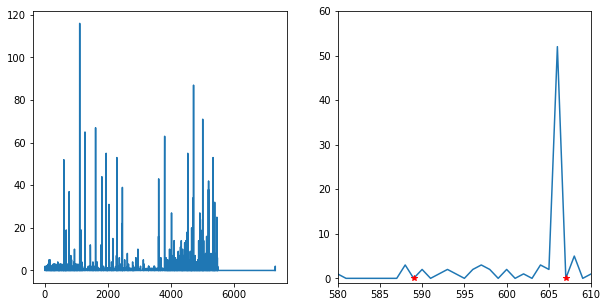

In [72]:
bug = bug_dic[710942]
bug.sort()
start_time = int(datetime.datetime.fromtimestamp(bug[0] // 86400 * 86400).timestamp())
end_time = int(datetime.datetime.fromtimestamp((bug[-1] // 86400 + 1) * 86400).timestamp())
data_stream = stream_generation2(bug, start_time, end_time)
fig = plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(data_stream)

plt.subplot(1, 2, 2)
plt.plot(data_stream)
plt.axis([580, 610, -1, 60])
plt.plot(589, data_stream[589], 'r*')
plt.plot(607, data_stream[607], 'r*')

plt.show()


## Visulization for Bug 739089

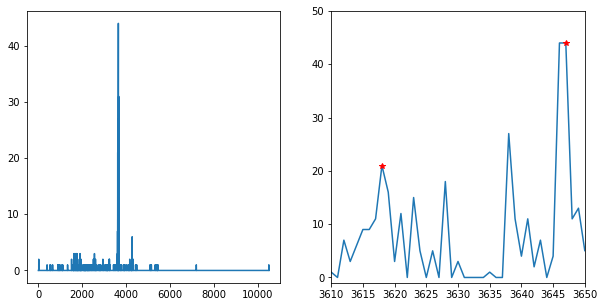

In [74]:
bug = bug_dic[739089]
bug.sort()
start_time = int(datetime.datetime.fromtimestamp(bug[0] // 86400 * 86400).timestamp())
end_time = int(datetime.datetime.fromtimestamp((bug[-1] // 86400 + 1) * 86400).timestamp())
data_stream = stream_generation2(bug, start_time, end_time)
fig = plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(data_stream)

plt.subplot(1, 2, 2)
plt.plot(data_stream)
plt.axis([3610, 3650, -1, 50])
plt.plot(3647, data_stream[3647], 'r*')
plt.plot(3618, data_stream[3618], 'r*')

plt.show()

## Visualization for Bug 840305

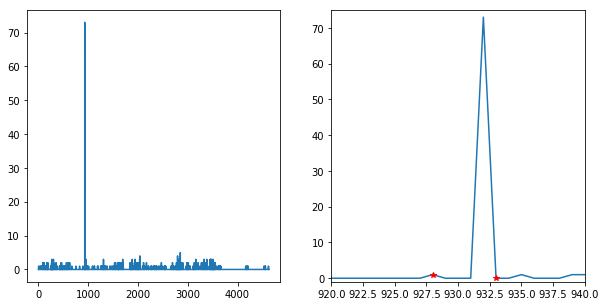

In [77]:
bug = bug_dic[840305]
bug.sort()
start_time = int(datetime.datetime.fromtimestamp(bug[0] // 86400 * 86400).timestamp())
end_time = int(datetime.datetime.fromtimestamp((bug[-1] // 86400 + 1) * 86400).timestamp())
data_stream = stream_generation2(bug, start_time, end_time)
fig = plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(data_stream)

plt.subplot(1, 2, 2)
plt.plot(data_stream)
plt.axis([920, 940, -1, 75])
plt.plot(933, data_stream[933], 'r*')
plt.plot(928, data_stream[928], 'r*')

plt.show()

## Visualization for Bug 906690

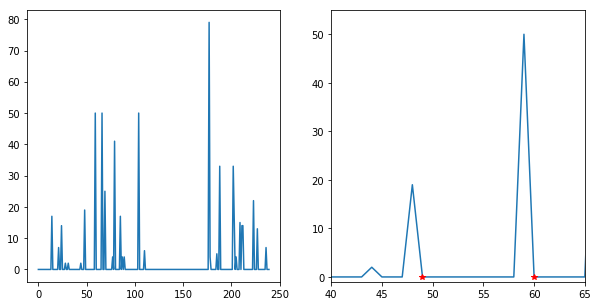

In [80]:
bug = bug_dic[906690]
bug.sort()
start_time = int(datetime.datetime.fromtimestamp(bug[0] // 86400 * 86400).timestamp())
end_time = int(datetime.datetime.fromtimestamp((bug[-1] // 86400 + 1) * 86400).timestamp())
data_stream = stream_generation2(bug, start_time, end_time)
fig = plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(data_stream)

plt.subplot(1, 2, 2)
plt.plot(data_stream)
plt.axis([40, 65, -1, 55])
plt.plot(60, data_stream[60], 'r*')
plt.plot(49, data_stream[49], 'r*')

plt.show()

## Visualization for Bug 913870

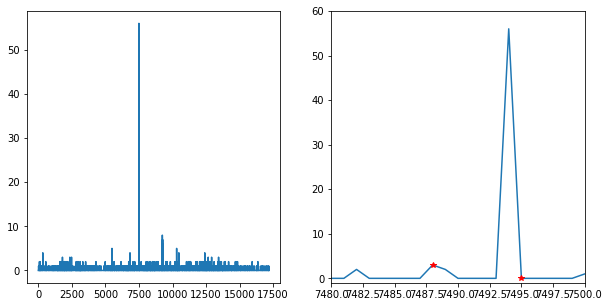

In [82]:
bug = bug_dic[913870]
bug.sort()
start_time = int(datetime.datetime.fromtimestamp(bug[0] // 86400 * 86400).timestamp())
end_time = int(datetime.datetime.fromtimestamp((bug[-1] // 86400 + 1) * 86400).timestamp())
data_stream = stream_generation2(bug, start_time, end_time)
fig = plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(data_stream)

plt.subplot(1, 2, 2)
plt.plot(data_stream)
plt.axis([7480, 7500, -1, 60])
plt.plot(7495, data_stream[7495], 'r*')
plt.plot(7488, data_stream[7488], 'r*')

plt.show()

## Visualization for Bug 918759

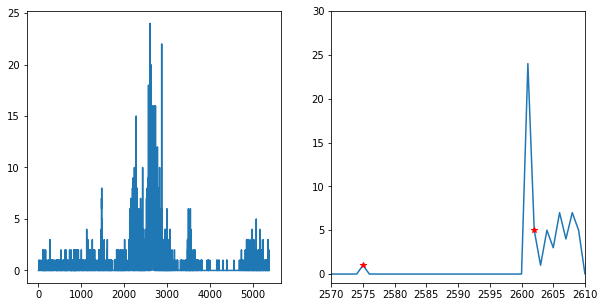

In [85]:
bug = bug_dic[918759]
bug.sort()
start_time = int(datetime.datetime.fromtimestamp(bug[0] // 86400 * 86400).timestamp())
end_time = int(datetime.datetime.fromtimestamp((bug[-1] // 86400 + 1) * 86400).timestamp())
data_stream = stream_generation2(bug, start_time, end_time)
fig = plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(data_stream)

plt.subplot(1, 2, 2)
plt.plot(data_stream)
plt.axis([2570, 2610, -1, 30])
plt.plot(2602, data_stream[2602], 'r*')
plt.plot(2575, data_stream[2575], 'r*')

plt.show()

## Visualization for Bug 934310 

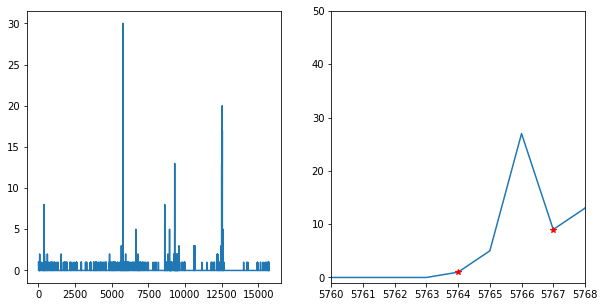

In [89]:
bug = bug_dic[934310]
bug.sort()
start_time = int(datetime.datetime.fromtimestamp(bug[0] // 86400 * 86400).timestamp())
end_time = int(datetime.datetime.fromtimestamp((bug[-1] // 86400 + 1) * 86400).timestamp())
data_stream = stream_generation2(bug, start_time, end_time)
fig = plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(data_stream)

plt.subplot(1, 2, 2)
plt.plot(data_stream)
plt.axis([5760, 5768, -1, 50])
plt.plot(5764, data_stream[5764], 'r*')
plt.plot(5767, data_stream[5767], 'r*')

plt.show()

## Visualization for Bug 980997

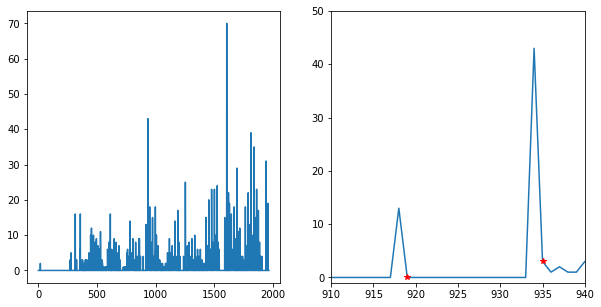

In [90]:
bug = bug_dic[980997]
bug.sort()
start_time = int(datetime.datetime.fromtimestamp(bug[0] // 86400 * 86400).timestamp())
end_time = int(datetime.datetime.fromtimestamp((bug[-1] // 86400 + 1) * 86400).timestamp())
data_stream = stream_generation2(bug, start_time, end_time)
fig = plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(data_stream)

plt.subplot(1, 2, 2)
plt.plot(data_stream)
plt.axis([910, 940, -1, 50])
plt.plot(919, data_stream[919], 'r*')
plt.plot(935, data_stream[935], 'r*')

plt.show()

## Visualization for Bug 989048

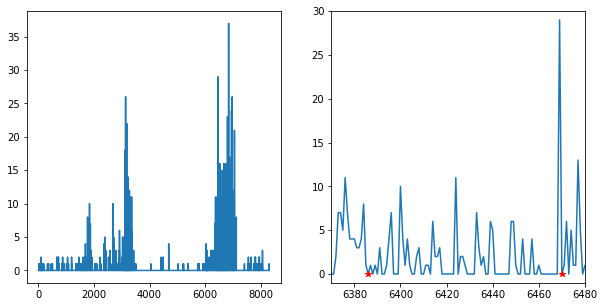

In [92]:
bug = bug_dic[989048]
bug.sort()
start_time = int(datetime.datetime.fromtimestamp(bug[0] // 86400 * 86400).timestamp())
end_time = int(datetime.datetime.fromtimestamp((bug[-1] // 86400 + 1) * 86400).timestamp())
data_stream = stream_generation2(bug, start_time, end_time)
fig = plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(data_stream)

plt.subplot(1, 2, 2)
plt.plot(data_stream)
plt.axis([6370, 6480, -1, 30])
plt.plot(6386, data_stream[6386], 'r*')
plt.plot(6470, data_stream[6470], 'r*')

plt.show()